In [1]:
import itertools as it
import warnings
from collections import deque
from typing import Callable, Dict

import multiprocess as mp
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm

from edgedroid.models import *

execution_time_models: Dict[str, Callable[[], ExecutionTimeModel]] = {
    "Low neuro"                  : lambda: ExpKernelRollingTTFETModel(neuroticism=0.0),
    "High neuro"                 : lambda: ExpKernelRollingTTFETModel(neuroticism=1.0),
    "ExGaussian fit,\nlow neuro" : lambda: DistExpKernelRollingTTFETModel(neuroticism=0.0, dist=stats.exponnorm),
    "ExGaussian fit,\nhigh neuro": lambda: DistExpKernelRollingTTFETModel(neuroticism=1.0, dist=stats.exponnorm),
    "Wang et al. (2019)"         : lambda: FittedNaiveExecutionTimeModel(dist=stats.norm)
}


def junjues_adaptive_sampling(
        repetition: int,
        ground_truth: str,
        estimator: str,
        number_of_steps: int,
        processing_delay: float,
        # latency_bound: float = 3.2,
        max_delta_t: float,
        alpha: float = 3.0,
) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gt_model = execution_time_models[ground_truth]()
        estimator_model = execution_time_models[estimator]()
    previous_ttf = processing_delay

    # max_ts = (latency_bound - processing_delay) / (5 - 1)

    min_sr = 1 / max_delta_t
    max_sr = 1 / processing_delay

    assert min_sr < max_sr

    rows = deque()
    total_duration = 0.0

    for step in range(number_of_steps):
        gt_model.advance(previous_ttf)
        estimator_model.advance(previous_ttf)

        instant = 0.0
        execution_time = gt_model.get_execution_time()
        samples = 0

        while instant <= execution_time:
            sr = min(min_sr + (alpha * (max_sr - min_sr) * estimator_model.get_cdf_at_instant(instant)), max_sr)
            instant = instant + (1 / sr)
            samples += 1

        duration = instant + processing_delay
        total_duration += duration
        ttf = duration - execution_time
        wait_time = ttf - processing_delay

        rows.append(
            {
                "ground_truth"       : ground_truth,
                "estimator"          : estimator,
                "proc_delay"         : processing_delay,
                "repetition"         : repetition,
                "step"               : step + 1,
                "execution_time"     : execution_time,
                "step_duration"      : duration,
                "cumulative_duration": total_duration,
                "ttf"                : ttf,
                "wait_time"          : wait_time,
                "samples"            : samples,
            }
        )

    return pd.DataFrame(rows)


ground_truth = "High neuro"
processing_delay = 0.3
max_delta_t = 2
repetitions = 90
num_steps = 100

results = deque()

with tqdm(total=len(execution_time_models) * repetitions) as bar, mp.Pool() as pool:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()


    def _errback(error):
        raise error


    for estimator, rep in it.product(execution_time_models.keys(), range(1, repetitions + 1)):
        pool.apply_async(
            junjues_adaptive_sampling,
            kwds=dict(
                repetition=rep,
                ground_truth=ground_truth,
                estimator=estimator,
                number_of_steps=num_steps,
                processing_delay=processing_delay,
                max_delta_t=max_delta_t,
            ),
            callback=_callback,
            error_callback=_errback,
        )

    pool.close()
    pool.join()

results = pd.concat(results)
model_cats = pd.CategoricalDtype(execution_time_models.keys(), ordered=False)
results["ground_truth"] = results["ground_truth"].astype(model_cats)
results["estimator"] = results["estimator"].astype(model_cats)
results

100%|██████████| 450/450 [00:11<00:00, 40.12it/s]


,ground_truth,estimator,proc_delay,repetition,step,execution_time,step_duration,cumulative_duration,ttf,wait_time,samples
0,High neuro,Low neuro,0.3,4,1,6.652774,7.117123,7.117123,0.464349,0.164349,12
1,High neuro,Low neuro,0.3,4,2,2.672502,4.108989,11.226111,1.436487,1.136487,2
2,High neuro,Low neuro,0.3,4,3,7.734432,8.317123,19.543234,0.582691,0.282691,16
3,High neuro,Low neuro,0.3,4,4,2.932647,4.108989,23.652223,1.176342,0.876342,2
4,High neuro,Low neuro,0.3,4,5,7.621245,8.017123,31.669346,0.395878,0.095878,15
...,...,...,...,...,...,...,...,...,...,...,...
95,High neuro,Wang et al. (2019),0.3,85,96,10.464673,11.053296,552.627055,0.588622,0.288622,28
96,High neuro,Wang et al. (2019),0.3,85,97,6.544503,6.853296,559.480351,0.308793,0.008793,14
97,High neuro,Wang et al. (2019),0.3,85,98,6.710223,7.153296,566.633647,0.443073,0.143073,15
98,High neuro,Wang et al. (2019),0.3,85,99,3.856889,4.418271,571.051918,0.561382,0.261382,6


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

In [3]:
# mean number of samples per rep
samples_per_rep = results.groupby(["estimator", "repetition"])["samples"].mean().reset_index()
samples_per_rep

,estimator,repetition,samples
0,Low neuro,1,8.92
1,Low neuro,2,6.81
2,Low neuro,3,7.09
3,Low neuro,4,7.36
4,Low neuro,5,7.61
...,...,...,...
445,Wang et al. (2019),86,10.92
446,Wang et al. (2019),87,9.72
447,Wang et al. (2019),88,9.86
448,Wang et al. (2019),89,12.19


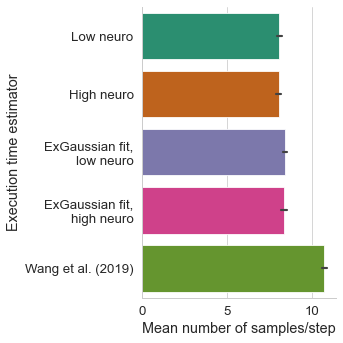

In [4]:
fg = sns.catplot(
    kind="bar",
    data=samples_per_rep,
    x="samples",
    y="estimator",
)
fg.set_axis_labels("Mean number of samples/step", "Execution time estimator")
plt.show()

In [5]:
import pingouin as pg

ix = pd.IndexSlice

ref_samples = samples_per_rep.loc[samples_per_rep["estimator"] == "Wang et al. (2019)", "samples"].to_numpy()
ref_mean = ref_samples.mean()


def diff_wrt_ref(samples: pd.Series) -> pd.Series:
    ttest = pg.ttest(samples.to_numpy(), ref_samples, alternative="two-sided")
    diff_raw = samples.mean() - ref_mean
    diff = diff_raw / ref_mean
    ci = ttest.at["T-test", "CI95%"]

    pval = ttest.at["T-test", "p-val"]
    sig_pval = pval < 0.05

    return pd.Series({
        "diff"     : diff,
        "diff_raw" : diff_raw,
        "p-val"    : pval,
        "p < 0.05" : sig_pval,
        "CI95_Low" : ci[0] / ref_mean,
        "CI95_High": ci[1] / ref_mean}, name="Result")

samples_diff = samples_per_rep.groupby("estimator")["samples"].apply(diff_wrt_ref).unstack(level=-1).reset_index()
samples_diff = samples_diff[samples_diff["estimator"] != "Wang et al. (2019)"]
samples_diff["estimator"] = samples_diff["estimator"].cat.remove_unused_categories()
samples_diff

,estimator,diff,diff_raw,p-val,p < 0.05,CI95_Low,CI95_High
0,Low neuro,-0.247188,-2.654111,0.0,True,-0.267294,-0.227247
1,High neuro,-0.250603,-2.690778,0.0,True,-0.27102,-0.230972
2,"ExGaussian fit,\nlow neuro",-0.214529,-2.303444,0.0,True,-0.234698,-0.19465
3,"ExGaussian fit,\nhigh neuro",-0.220148,-2.363778,0.0,True,-0.242148,-0.198375


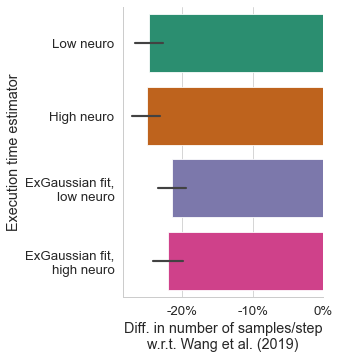

,estimator,level_1,values
0,Low neuro,CI95_Low,-0.267294
1,Low neuro,CI95_High,-0.227247
2,Low neuro,diff,-0.247188
3,High neuro,CI95_Low,-0.27102
4,High neuro,CI95_High,-0.230972
5,High neuro,diff,-0.250603
6,"ExGaussian fit,\nlow neuro",CI95_Low,-0.234698
7,"ExGaussian fit,\nlow neuro",CI95_High,-0.19465
8,"ExGaussian fit,\nlow neuro",diff,-0.214529
9,"ExGaussian fit,\nhigh neuro",CI95_Low,-0.242148


In [6]:
import matplotlib.ticker as tkr

plot_data = samples_diff.set_index("estimator")[["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(columns={0: "values"})

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="estimator",
    x="values",
    # hue="Configuration",
    aspect=1,
    # yerr=duration_diff["CI95%"].to_numpy(),
)
fg.set_axis_labels("Diff. in number of samples/step\nw.r.t. Wang et al. (2019)", "Execution time estimator")
for ax in fg.axes.flat:
    # ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    # ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}s"))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%"))
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
plt.show()

plot_data